### Data Description
#### A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service")

In [1]:
!pip3 --version
!pip install pyyaml h5py  
!pip install contractions

pip 20.1.1 from /Users/sharadkarna/opt/anaconda3/lib/python3.8/site-packages/pip (python 3.8)
     |████████████████████████████████| 321 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 260 kB 29.0 MB/s eta 0:00:01
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp38-cp38-macosx_10_9_x86_64.whl size=32368 sha256=04980275e09ae7fe1e7ac506548354f0a1811ffe3a74a47089bfa358f5ec729a
  Stored in directory: /Users/sharadkarna/Library/Caches/pip/wheels/74/bc/b8/e5f739a84005620cfe66d3fcb8bb182e309d6056bc6700b60e
Successfully built pyahocorasick


### 1. Import the libraries, load dataset, print shape of data, data description. (5 Marks)

In [24]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import contractions                                     
import re, string, unicodedata  
pd.set_option('display.max_colwidth',None)

# Importing necessary NLTK libraries
import nltk
from nltk.corpus import stopwords                      
from nltk.tokenize import word_tokenize, sent_tokenize  
from nltk.stem.wordnet import WordNetLemmatizer         
from nltk.corpus import stopwords                       
from nltk.stem import PorterStemmer                     
from nltk.tokenize import word_tokenize

# Importing necessary SkLearn libraries
from sklearn.feature_extraction.text import CountVectorizer          
from sklearn.feature_extraction.text import TfidfVectorizer              
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

nltk.download('stopwords')                              
nltk.download('punkt')
nltk.download('wordnet')

from bs4 import BeautifulSoup
%matplotlib inline




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sharadkarna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sharadkarna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sharadkarna/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [17]:
# Importing the dataset
df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [18]:
# Shape of the dataset
df.shape

(14640, 15)

In [19]:
# Info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [20]:
# Description of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


### 2. Understand of data-columns: (5 Marks)

In [94]:
# Drop all other columns except “text” and “airline_sentiment”.
df_cp = df.loc[:14640,['airline_sentiment','text']]

In [95]:
# Check the shape of the dataset
df_cp.shape

(14640, 2)

In [96]:
# Print first 5 rows of data
df_cp.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


### 3. Text pre-processing: Data preparation. (20 Marks)

In [97]:
# HTML tag removal
def strip_html_tag(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df_cp['text'] = df_cp['text'].apply(lambda x: strip_html_tag(x))
df_cp.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [98]:
# Remove the numbers
def remove_numbers(text):
  text = re.sub(r"\d+", "", str(text))
  return text

df_cp["text"] = df_cp["text"].apply(lambda x: remove_numbers(x))
df_cp.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [99]:
# Tokenization
df_cp["text"] = df_cp.apply(lambda row: nltk.word_tokenize(row["text"]), axis = 1)
df_cp.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, 've, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, n't, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, 's, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, 's, a, really, big, bad, thing, about, it]"


In [100]:
# Remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r"[^a-zA-z0-9\s]" if not remove_digits else r"[^a-zA-z\s]"
    text = re.sub(pattern, "", text)
    return text

df_cp.head()


,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, 've, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, n't, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, 's, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, 's, a, really, big, bad, thing, about, it]"


In [101]:
# Remove punctuations
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r"[^\w\s]", "", word)
        if new_word != "":
            new_words.append(new_word)
    return new_words

df_cp["text"] = df_cp["text"].apply(lambda x: remove_punctuation(x))
df_cp.head()

,airline_sentiment,text
0,neutral,"[VirginAmerica, What, dhepburn, said]"
1,positive,"[VirginAmerica, plus, you, ve, added, commercials, to, the, experience, tacky]"
2,neutral,"[VirginAmerica, I, did, nt, today, Must, mean, I, need, to, take, another, trip]"
3,negative,"[VirginAmerica, it, s, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]"
4,negative,"[VirginAmerica, and, it, s, a, really, big, bad, thing, about, it]"


In [102]:
# Conversion to lower case
def to_lowercase(words):
    new_words = []                        
    for word in words:
        new_word = word.lower()           
        new_words.append(new_word)        
    return new_words

df_cp["text"] = df_cp["text"].apply(lambda x: to_lowercase(x))
df_cp.head()

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, said]"
1,positive,"[virginamerica, plus, you, ve, added, commercials, to, the, experience, tacky]"
2,neutral,"[virginamerica, i, did, nt, today, must, mean, i, need, to, take, another, trip]"
3,negative,"[virginamerica, it, s, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]"
4,negative,"[virginamerica, and, it, s, a, really, big, bad, thing, about, it]"


In [103]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

df_cp["text"] = df_cp["text"].apply(lambda x: lemmatize_list(x))
df_cp.head()

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, say]"
1,positive,"[virginamerica, plus, you, ve, add, commercials, to, the, experience, tacky]"
2,neutral,"[virginamerica, i, do, nt, today, must, mean, i, need, to, take, another, trip]"
3,negative,"[virginamerica, it, s, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, face, they, have, little, recourse]"
4,negative,"[virginamerica, and, it, s, a, really, big, bad, thing, about, it]"


In [104]:
# Join the words in the list to convert back to text string in the dataframe. 
def join_words(words):
    return " ".join(words)

df_cp["text"] = df_cp.apply(lambda row: join_words(row["text"]), axis=1)

In [105]:
# Print first 5 rows of data after pre-processing.
df_cp.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus you ve add commercials to the experience tacky
2,neutral,virginamerica i do nt today must mean i need to take another trip
3,negative,virginamerica it s really aggressive to blast obnoxious entertainment in your guests face they have little recourse
4,negative,virginamerica and it s a really big bad thing about it


### 4. Vectorization: (10 Marks)

#### Using CountVectorizer

In [106]:
# Use CountVectorizer
count_vectorizer = CountVectorizer()
count_data_features = count_vectorizer.fit_transform(df_cp["text"])

# Converting the data features to array.
count_data_features = count_data_features.toarray()                        

count_data_features.shape

(14640, 12155)

#### Using TfidfVectorier

In [108]:
# Use Tfidfvectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_data_features = tfidf_vectorizer.fit_transform(df_cp["text"])

# Converting the data features to array.
tfidf_data_features = tfidf_data_features.toarray()

tfidf_data_features.shape

(14640, 12155)

### 5. Fit and evaluate model using both type of vectorization. (6+6 Marks)

#### Fit and evaluate model using CountVectorizer vectorization

In [110]:
labels = df_cp["airline_sentiment"]
labels = labels.map({"negative":-1, "neutral":0, "positive":1})

In [111]:
labels

0        0
1        1
2        0
3       -1
4       -1
        ..
14635    1
14636   -1
14637    0
14638   -1
14639    0
Name: airline_sentiment, Length: 14640, dtype: int64

In [112]:
# Spliting the data into training and testing set.
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(count_data_features, labels, test_size=0.3, random_state=42)

In [150]:
# Random Forest to build model for the classification 
random_forest = RandomForestClassifier(n_estimators = 20, n_jobs = -1) 

forest_count = random_forest.fit(X_train_c, y_train_c)

print(forest_count)

RandomForestClassifier(n_estimators=20, n_jobs=-1)


In [147]:
# Printing cross validation score using random forest
cross_val_rfc = np.mean(cross_val_score(forest_count, count_data_features, labels, cv = 10))
print(cross_val_rfc)

0.730327868852459


In [114]:
# Prediction of result of test data using model countVectorization
result_count = forest_count.predict(X_test_c)
result_count

array([ 1, -1, -1, ..., -1, -1, -1])

In [116]:
# Calculating and printing the result for confusion matrix 
confumat_count = confusion_matrix(y_test_c, result_count)
print(confumat_count)

[[2683  109   22]
 [ 480  363   41]
 [ 292   91  311]]


In [153]:
# Using logistic regression to build model for the classification
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 2000, multi_class = "ovr")
logistic_count = log_reg.fit(X_train_c, y_train_c)

In [152]:
# printing cross validation score using logistic regression
cross_val_lgc = np.mean(cross_val_score(logistic_count, count_data_features, labels, cv = 10))
print(cross_val_lgc)

0.7784836065573771


In [127]:
# Prediction of result of test data using model countVectorization
result_count_lg = log_reg.predict(X_test_c)
result_count_lg

array([ 1, -1, -1, ..., -1, -1, -1])

In [128]:
# Calculating and printing the result for confusion matrix 
confumat_count_lg = confusion_matrix(y_test_c, result_count_lg)
print(confumat_count_lg)

[[2551  195   68]
 [ 275  530   79]
 [ 119   96  479]]


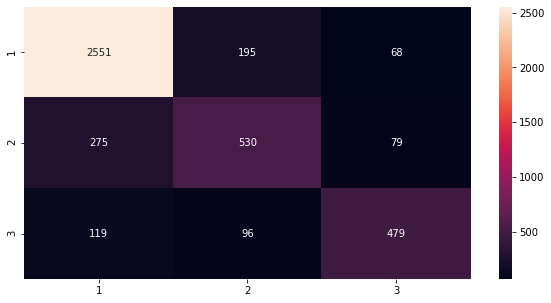

In [137]:
# Plotting the confusion matrix 

import matplotlib.pyplot as plt
import seaborn as sns

df_cm = pd.DataFrame(confumat_count_lg, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10, 5))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show();

#### Fit and evaluate model using TfidfVectorizer vectorization

In [119]:
# Spliting the data into training and testing set.
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(tfidf_data_features, labels, test_size=0.3, random_state=42)

In [145]:
# Random Forest to build model for the classification 
random_forest = RandomForestClassifier(n_estimators = 20, n_jobs = -1) 

forest_tfidf = random_forest.fit(X_train_t, y_train_t)

print(forest_tfidf)

RandomForestClassifier(n_estimators=20, n_jobs=-1)


In [142]:
# Printing cross validation score using random forest
cross_val_rf = np.mean(cross_val_score(forest_tfidf, tfidf_data_features, labels, cv = 10))
print(cross_val_rf)

0.7196038251366119


In [121]:
# Prediction of result of test data using model Tfidfvectorizer
result_tfidf = forest_tfidf.predict(X_test_t)
result_tfidf

array([ 1, -1, -1, ..., -1, -1, -1])

In [122]:
# Calculating and printing the result for confusion matrix 
confumat_tfidf = confusion_matrix(y_test_t, result_tfidf)
print(confumat_tfidf)

[[2696  102   16]
 [ 509  346   29]
 [ 317   90  287]]


In [141]:
# Using logistic regression to build model for the classification
log_reg = LogisticRegression(max_iter = 2000, multi_class = "ovr")
logistic_tfidf = log_reg.fit(X_train_t, y_train_t)

In [138]:
# Printing cross validation score using logistic regression
cross_val_lg = np.mean(cross_val_score(logistic_tfidf, tfidf_data_features, labels, cv = 10))
print(cross_val_lg)

0.7719945355191257


In [132]:
# Prediction of result of test data using model Tfidfvectorization
result_tfidf_lg = log_reg.predict(X_test_t)
result_tfidf_lg

array([ 1, -1, -1, ..., -1, -1, -1])

In [133]:
# Calculating and printing the result for confusion matrix 
confumat_tfidf_lg = confusion_matrix(y_test_t, result_tfidf_lg)
print(confumat_tfidf_lg)

[[2680  107   27]
 [ 391  455   38]
 [ 195   84  415]]


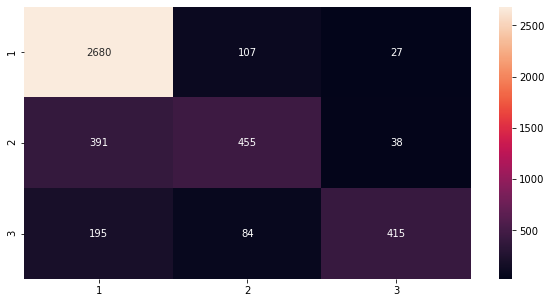

In [136]:
# Plotting the confusion matrix 
df_cm = pd.DataFrame(confumat_tfidf_lg, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10, 5))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show();

### 6. Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset. (8 Marks)

In [161]:
# Comparisions of cross validation score of diffrent models on different vectorizer
models = [["CountVectorizer Random Forest", cross_val_rfc], ["CountVectorizer Logistic Regression", cross_val_lgc ], ["TfidfVectorizer Random Forest", cross_val_rf], ["Tfidfvectorizer Logistic Regression", cross_val_lg]]
data_fm = pd.DataFrame(models, columns = ["Models", "Cross Validation Score"])
data_fm

,Models,Cross Validation Score
0,CountVectorizer Random Forest,0.730328
1,CountVectorizer Logistic Regression,0.778484
2,TfidfVectorizer Random Forest,0.719604
3,Tfidfvectorizer Logistic Regression,0.771995


###### Summarization

1. From the above table observation, we can see among the two models Logistic Regression seems to be fit better than Random forest on both vectorization models as it's cross validation score is higher than the Random Forest. And at the same time it is also not seem to be overfitting.
2. I have used the given dataset(Tweets.csv) which contains positive, negative and neutral words in text format and their sentiment score on the scale of 1 to 3 i.e 3: positive, 2: neutral, and 1: negative.
3. I have used couple of models i.e. Random forest and Logistic Regression for text classification and sentiment analysis.  
4. While preprocessing the data, I have used different techniques and libraries to convert them into numbers so that it would be easier to feed the data in model.
5. The result for the test data was predicted after building the classification model.
6. The accuracy of the model can be increase by using different variations of Pre-processing techniques.